# COS 711: Assignment 3 - Zindi Deep Learning

This assignment sees will make use of a RNN and a Boosting Descent Algorithm (curse the example for using what I wanted to use but never the less, we will be okay)

### 1. Getting the data in

$\cos^2(x) + \sin^2(x) = 1$

In [15]:
!pip install PyDrive

In [16]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import math
import gc
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [17]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [18]:
downloadedTrain = drive.CreateFile({'id':"1M0Zj1fZKIocOZBXAbk8GJCkEdpCGIoay"})   # replace the id with id of file you want to access
downloadedTest = drive.CreateFile({'id':"1FtJUikAfXCkLj4c_DldLFhRHbzRG_rpZ"})
downloadedTrain.GetContentFile('Train.csv')        # replace the file name with your file
downloadedTest.GetContentFile('Test.csv')

Importing the data:

In [19]:
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")
# sample_sub=pd.read_csv("./data/sample_sub.csv")
train.head()

# 15539 observations

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


### 2. Adjusting and engineering the data for ease of use (as suggested in the 

In [20]:
# covert features  from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

# define the feature list
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]

# for each field: split on the commas, replace "nan" with np.Nan
# So  now we have 2-dimensional arrays
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature]=test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

Data engineering

In [21]:
# aggreagation may be useful. We'll see
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
# For an array x, return the non-null vals. Smaller array though (?)    
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

In [22]:
# join the test and training sets for transformation 
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target']

In [23]:
for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


In [24]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:19<00:00,  3.33s/it]


In [25]:
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

In [26]:
# drop the initial rows used to make the new ones 
data.drop(features,1,inplace=True)

In [27]:
# Spilt the data again
train=data[data.target.notnull()].reset_index(drop=True)
test=data[data.target.isna()].reset_index(drop=True)

In [28]:
del data  
gc.collect()

302

In [29]:
train.head(3)

,ID,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,min_precip,mean_precip,std_precip,var_precip,median_precip,ptp_precip,max_rel_humidity,min_rel_humidity,mean_rel_humidity,std_rel_humidity,var_rel_humidity,median_rel_humidity,ptp_rel_humidity,max_wind_dir,min_wind_dir,mean_wind_dir,std_wind_dir,var_wind_dir,median_wind_dir,ptp_wind_dir,max_wind_spd,min_wind_spd,mean_wind_spd,std_wind_spd,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,...,newrel_humidity114,newwind_dir114,windspeed114,atmospherepressure114,newtemp115,newprecip115,newrel_humidity115,newwind_dir115,windspeed115,atmospherepressure115,newtemp116,newprecip116,newrel_humidity116,newwind_dir116,windspeed116,atmospherepressure116,newtemp117,newprecip117,newrel_humidity117,newwind_dir117,windspeed117,atmospherepressure117,newtemp118,newprecip118,newrel_humidity118,newwind_dir118,windspeed118,atmospherepressure118,newtemp119,newprecip119,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
0,ID_train_0,C,45.126304,27.208333,19.275000,22.299527,2.594011,6.728895,21.358333,7.933333,0.000,0.0,0.000000,0.000000,0.000000,0.0,0.000,0.891500,0.510818,0.758530,0.120234,0.014456,0.806292,0.380682,345.726333,6.535299,209.574655,120.231802,14455.686315,220.039988,339.191034,1.517500,0.162500,0.677348,0.394041,0.155268,0.666250,1.355000,87.871667,87.614167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_train_1,D,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,0.561,0.0,0.007025,0.051706,0.002673,0.0,0.561,0.979250,0.403083,0.758058,0.160952,0.025906,0.791000,0.576167,357.730286,3.543198,177.109855,96.802929,9370.807133,153.164843,354.187088,3.009167,0.248333,0.899208,0.539199,0.290736,0.744167,2.760833,90.725000,90.056667,...,0.600083,97.603374,1.395833,90.481667,30.233333,0.0,0.556917,69.085542,1.589167,90.354167,30.583333,0.0,0.520833,171.660338,1.695833,90.2725,28.466667,0.0,0.603083,183.291765,2.548333,90.266667,26.991667,0.0,0.651000,213.937567,1.369167,90.325833,26.025000,0.0,0.649250,73.528733,1.475833,90.439167,21.45,0.561,0.797333,296.967254,1.019167,90.529167
2,ID_train_10,A,32.661304,31.841667,18.458333,24.112317,3.776377,14.261020,23.304167,13.383333,7.804,0.0,0.151767,0.798401,0.637445,0.0,7.804,0.930333,0.376750,0.712944,0.168129,0.028267,0.766458,0.553583,357.265773,0.581510,201.373211,92.105195,8483.367004,208.901301,356.684263,2.751667,0.331667,1.038656,0.585221,0.342484,0.942500,2.420000,88.813333,87.982500,...,0.881333,NaN,NaN,88.448333,23.541667,0.0,0.734750,NaN,NaN,88.500000,26.408333,0.0,0.603000,NaN,NaN,88.4950,28.075000,0.0,0.496667,NaN,NaN,88.515833,29.241667,0.0,0.459583,NaN,NaN,88.475833,30.091667,0.0,0.437917,NaN,NaN,88.415833,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
from sklearn.model_selection import train_test_split
data, labels = np.arange(10).reshape((5, 2)), range(5)
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, random_state=42)

labels_train

[4, 2, 0, 3]

In [31]:
l

NameError: ignored

In [ ]:
def lstm_restructure2():
  

In [32]:
# Now we need to restructeure the data for the LSTM model
# We want:
#  [{ID_train_0: [temps],[precip],[humidity],[wind_dir],[wind_spd],[atmos_pressure]},
#   {ID_train_1: [temps],[precip],[humidity],[wind_dir],[wind_spd],[atmos_pressure]},
#   ...
#   {ID_train_100000: [temps],[precip],[humidity],[wind_dir],[wind_spd],[atmos_pressure]}
#  ]
#
# And then the targets

def lstm_feature_structure(dataset):
  # Remove the aggregation 
  nonAggCols = [c for c in dataset.columns if ("max" not in c and 
                                               "min" not in c and 
                                               "mean" not in c and 
                                               "std" not in c and 
                                               "var" not in c and 
                                               "median" not in c and 
                                               "ptp" not in c)]
                                             
  dataset = dataset[nonAggCols]

  tempsCols = [c for c in dataset.columns if "temp" in c]
  temps = dataset[tempsCols]
  print (temps[0])

  precipsCols = [c for c in dataset.columns if "precip" in c]
  precips = dataset[precipsCols]

  humiditysCols = [c for c in dataset.columns if "humidity" in c]
  humiditys = dataset[humiditysCols]

  winddirectionsCols = [c for c in dataset.columns if "wind_dir" in c]
  winddirections = dataset[winddirectionsCols]

  windspeedsCols = [c for c in dataset.columns if "windspeed" in c]
  windspeeds = dataset[windspeedsCols]

  atmospherepressuresCols = [c for c in dataset.columns if "atmospherepressure" in c]
  atmospherepressures = dataset[atmospherepressuresCols]
  
  result_array = np.empty((0, 6, 121, 1))
  '''
  # Brute force (._.)
  for i in range(temps.values.shape[0]):
    result_array2 = np.empty((0, 121))
    result_array2 = np.append(result_array2, [temps.values[i]], axis=0)
    result_array2 = np.append(result_array2, [precips.values[i]], axis=0)
    result_array2 = np.append(result_array2, [humiditys.values[i]], axis=0)
    result_array2 = np.append(result_array2, [winddirections.values[i]], axis=0)
    result_array2 = np.append(result_array2, [windspeeds.values[i]], axis=0)
    result_array2 = np.append(result_array2, [atmospherepressures.values[i]], axis=0)

    result_array = np.append(result_array, [result_array2], axis=0)
  '''

  return result_array2



lstmdata = lstm_feature_structure(train)
lstmdata.shape



KeyError: ignored

In [34]:
print(lstmdata)
lstm_target =train['target'].values


[[[2.69090909e+01 2.72083333e+01 2.61833333e+01 ...            nan
              nan            nan]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ...            nan
              nan            nan]
  [5.10818182e-01 5.35416667e-01 6.14500000e-01 ...            nan
              nan            nan]
  [2.72902752e+02 1.04565241e+02 1.67177225e+02 ...            nan
              nan            nan]
  [8.00909091e-01 1.07333333e+00 1.51750000e+00 ...            nan
              nan            nan]
  [8.77772727e+01 8.76525000e+01 8.76141667e+01 ...            nan
              nan            nan]]

 [[2.25333333e+01 2.17166667e+01 2.08333333e+01 ... 2.69916667e+01
   2.60250000e+01 2.14500000e+01]
  [1.02000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 5.61000000e-01]
  [7.44583333e-01 8.08083333e-01 9.11166667e-01 ... 6.51000000e-01
   6.49250000e-01 7.97333333e-01]
  [2.81664310e+02 8.91562926e+01 8.19685389e+01 ... 2.13937567e+02
   7.35287330e+01 2.96

In [35]:
Experiment_name="simple_model"

In [36]:
import os
os.makedirs("proc_data", exist_ok=True)
os.makedirs("model_save/lgbm/{}".format(Experiment_name), exist_ok=True)
# os.makedirs("model_save/catboost/{}".format(Experiment_name), exist_ok=True)
# os.makedirs("model_save/xgboost/{}".format(Experiment_name), exist_ok=True)
os.makedirs("model_save/lstm/{}".format(Experiment_name), exist_ok=True)

In [37]:
# Establish number of folds for K-Fold Cross Validation

try:
    folds=pd.read_csv("./proc_data/folds_id.csv")
    train=train.merge(folds,on="ID",how="left")
    train.fold.nunique()
except: 
    #  you run this cell  only for the first time 
    from sklearn.model_selection import KFold 
    kfold=KFold(n_splits=5,shuffle=True,random_state=321) 
    train.reset_index(drop=True,inplace=True)
    folds=train[["ID"]].copy()
    folds["fold"]=0
    for fold,(tr_indx,val_ind) in enumerate(kfold.split(folds)) : 
        folds.loc[val_ind,"fold"]=fold
    folds.to_csv("./proc_data/folds_id.csv",index=False)
    train=train.merge(folds,on="ID",how="left")
    
    del folds

### 3. Use LGBM Model for this data

In [38]:
train.columns

Index(['ID', 'location', 'target', 'max_temp', 'min_temp', 'mean_temp',
       'std_temp', 'var_temp', 'median_temp', 'ptp_temp',
       ...
       'newwind_dir119', 'windspeed119', 'atmospherepressure119', 'newtemp120',
       'newprecip120', 'newrel_humidity120', 'newwind_dir120', 'windspeed120',
       'atmospherepressure120', 'fold'],
      dtype='object', length=772)

In [39]:
target_name="target"
id_name="ID"
features_to_remove=[target_name,id_name,"fold","location"]
features=train.columns.tolist()
features=[ fea for fea in  features if fea not in features_to_remove  ]


In [40]:
from sklearn.metrics import mean_squared_error

def metric(y,x):
    return np.sqrt(mean_squared_error(x,y))

def metric2 (y,x):
    return np.abs(y-x)    

In [41]:
import  lightgbm as lgbm 
import xgboost as xgb 

!pip install catboost
import catboost as cat 

from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, GRU
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [62]:


def train_function(model,train,test,params,other_params,target_name,features,metric):
    # Using the cross validation
    folds_num=train.fold.nunique()
    validation=train[[id_name,"fold",target_name]].copy()
    validation["pred_"+target_name]=0
    sub=test[[id_name]].copy()
    sub[target_name]=0
    
    for fold in np.sort(train.fold.unique()):
        print("#"*50+" {} ".format(fold)+"#"*50)
        os.makedirs("model_save/lgbm/{}/{}".format(Experiment_name,str(int(fold))), exist_ok=True)
        X_train=train[train.fold!=fold]
        X_val=train[train.fold==fold]
        
        train_pred,validation_pred,test_pred=model(X_train,X_val,test,params,other_params)
        
        validation.loc[validation.fold==fold,"pred_"+target_name]=validation_pred
        sub[target_name]+=test_pred/folds_num
        train_score=metric(X_train[target_name],train_pred)
        val_score=metric(X_val[target_name],validation_pred)
        print("train score : {} validation score : {}".format(round(train_score,4),round(val_score,4)))

    final_validation_score=metric(validation[target_name],validation["pred_"+target_name])
    print("final validation score : {}".format(final_validation_score))
        
    return sub,validation,final_validation_score

def train_function2(model, train_input, train_targets, target_name, features, metric):
    # Just a regular partition of the data
    # folds_num=train.fold.nunique()
    # validation=train[[id_name,"fold",target_name]].copy()
    # validation["pred_"+target_name]=0
    print(train_input.shape)
    acc_per_fold = []
    loss_per_fold = []
    accuracy,loss=model(train_input, train_targets)
    '''
    kfold = KFold(n_splits=5, shuffle=True)
    count = 0
    for train, test in kfold.split(train_input, train_targets):
      print("#"*50+" {} ".format(count)+"#"*50)
      os.makedirs("model_save/lstm/{}/{}".format(Experiment_name,str(int(count))), exist_ok=True)
      accuracy,loss=model(train,test)
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])
      count = count + 1
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')


    '''
    '''
    for fold in np.sort(train.fold.unique()):
        print("#"*50+" {} ".format(fold)+"#"*50)
        os.makedirs("model_save/lstm/{}/{}".format(Experiment_name,str(int(fold))), exist_ok=True)
        X_train=train[train.fold!=fold]
        X_val=train[train.fold==fold]
        
        train_pred,validation_pred,test_pred=model(X_train,X_val,test)
        
        validation.loc[validation.fold==fold,"pred_"+target_name]=validation_pred
        # sub[target_name]+=test_pred/folds_num
        train_score=metric(X_train[target_name],train_pred)
        val_score=metric(X_val[target_name],validation_pred)
        print("train score : {} validation score : {}".format(round(train_score,4),round(val_score,4)))

    final_validation_score=metric(validation[target_name],validation["pred_"+target_name])
    print("final validation score : {}".format(final_validation_score))
    '''
        
    return 0,0    

def lgbm_model(X_train,X_val,X_test,params,other_params):
    dtrain = lgbm.Dataset(data=X_train[features], label=X_train[target_name], feature_name=features)
    dval = lgbm.Dataset(data=X_val[features], label=X_val[target_name], feature_name=features)

    model = lgbm.train(
        params=params,
        train_set=dtrain,
        num_boost_round=other_params["num_boost_round"],
        valid_sets=(dtrain, dval),
        early_stopping_rounds=other_params["early_stopping_rounds"],
        verbose_eval=other_params["verbose_eval"],
    )        
    best_iteration = model.best_iteration
    train_pred=model.predict(X_train[features], num_iteration=best_iteration)
    validation_pred=model.predict(X_val[features], num_iteration=best_iteration)
    test_pred=model.predict(X_test[features], num_iteration=best_iteration)
        
    return train_pred,validation_pred,test_pred

In [71]:
from keras import backend

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def lstm_model(X_train, X_y):
    dtrain = X_train
    dresult =X_y
    # dval = X_val[features].values.reshape(X_val[features].shape[0],X_val[features].shape[1],1)
    # print(dtrain)

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(dtrain.shape[0],dtrain.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])

    model.fit(x=dtrain, y=dresult, epochs=1, verbose=1000, batch_size=100)
            
    train_pred=model.predict(dtrain, verbose=0)
    #validation_pred=model.predict(X_val[features].values.reshape(X_val[features].shape[0],X_val[features].shape[1],1), verbose=0)
    fold_no = 0
    scores = model.evaluate(dtrain, dresult, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    # acc_per_fold.append(scores[1] * 100)
    # loss_per_fold.append(scores[0])
    
        
    return scores[1]*100, scores[0]

In [ ]:
other_params={"num_boost_round":50000000,
              "early_stopping_rounds":50,
              "verbose_eval":1000,
}
lgbm_params = {
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "boosting_type": "goss",
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_threads": 16,
    "objective": "regression",
    "metric": "rmse",
    "seed": 2020,
}

In [72]:
# LSTM
train_function2(model=lstm_model,
                                    train_input=lstmdata,
                                    train_targets = lstm_target,
                                    target_name=target_name,
                                    features=features,
                                    metric=metric)

#print (validation,score)




(15539, 6, 121)


ValueError: ignored

In [38]:
# LGBM
'''
sub,validation,score=train_function(model=lstm_model,
                                    train=train,
                                    test=test,
                                    params=lgbm_params,
                                    other_params=other_params,
                                    target_name=target_name,
                                    features=features,
                                    metric=metric)
'''
train[target_name].shape[1]

IndexError: ignored

In [ ]:
os.makedirs("subs", exist_ok=True)

In [ ]:
sub.to_csv("./subs/lgbm_{}.csv".format(round(score,2)),index=False)

In [ ]:
sub.to_csv("./subs/lstm_{}.csv".format(round(score,2)),index=False)

### 3. Use LSTM Model for this data

# LSTM APPROACH

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, GRU, Lambda
from tensorflow.keras.layers import Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model
import numpy as np

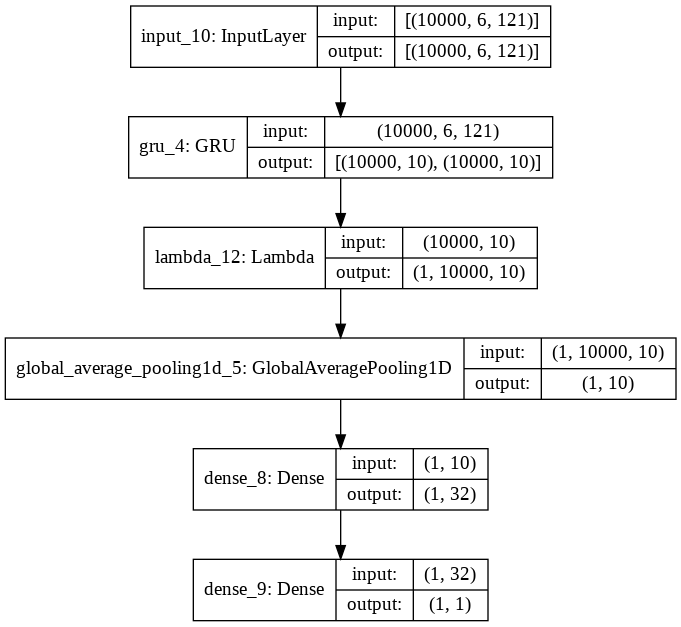

In [47]:
def make_model(batch_shape):
    ipt  = Input(batch_shape=batch_shape)
    # x    = Lambda(lambda x: K.squeeze(x, 0))(ipt)
    x, s = GRU(10, return_state=True)(ipt) # s == last returned state 
    x    = Lambda(lambda x: K.expand_dims(x, 0))(x)
    x    = GlobalAveragePooling1D()(x)  # averages along axis1 (original axis2)
    x    = Dense(32, activation='relu')(x)
    out  = Dense(1,  activation='sigmoid')(x)

    model = Model(ipt, out)
    model.compile('adam', 'binary_crossentropy')
    return model

def make_data(batch_shape):
    return (np.random.randn(*batch_shape),
            np.random.randint(0, 2, (batch_shape[0], 1)))

model = make_model((10000, 6, 121))
#3 model.summary()  # see model structure
plot_model(model, show_shapes=True)